In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate,GlobalAveragePooling2D, Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

### **Inception Model on Images with depth 3 (Original Size of the data which is 32,32,3)**


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv2_96_Filter (Conv2D)    (None, 32, 32, 96)           384       ['input_4[0][0]']             
                                                                                                  
 Conv3_16_Filter (Conv2D)    (None, 32, 32, 16)           64        ['input_4[0][0]']             
                                                                                                  
 MaxPooling (MaxPooling2D)   (None, 32, 32, 3)            0         ['input_4[0][0]']             
                                                                                            

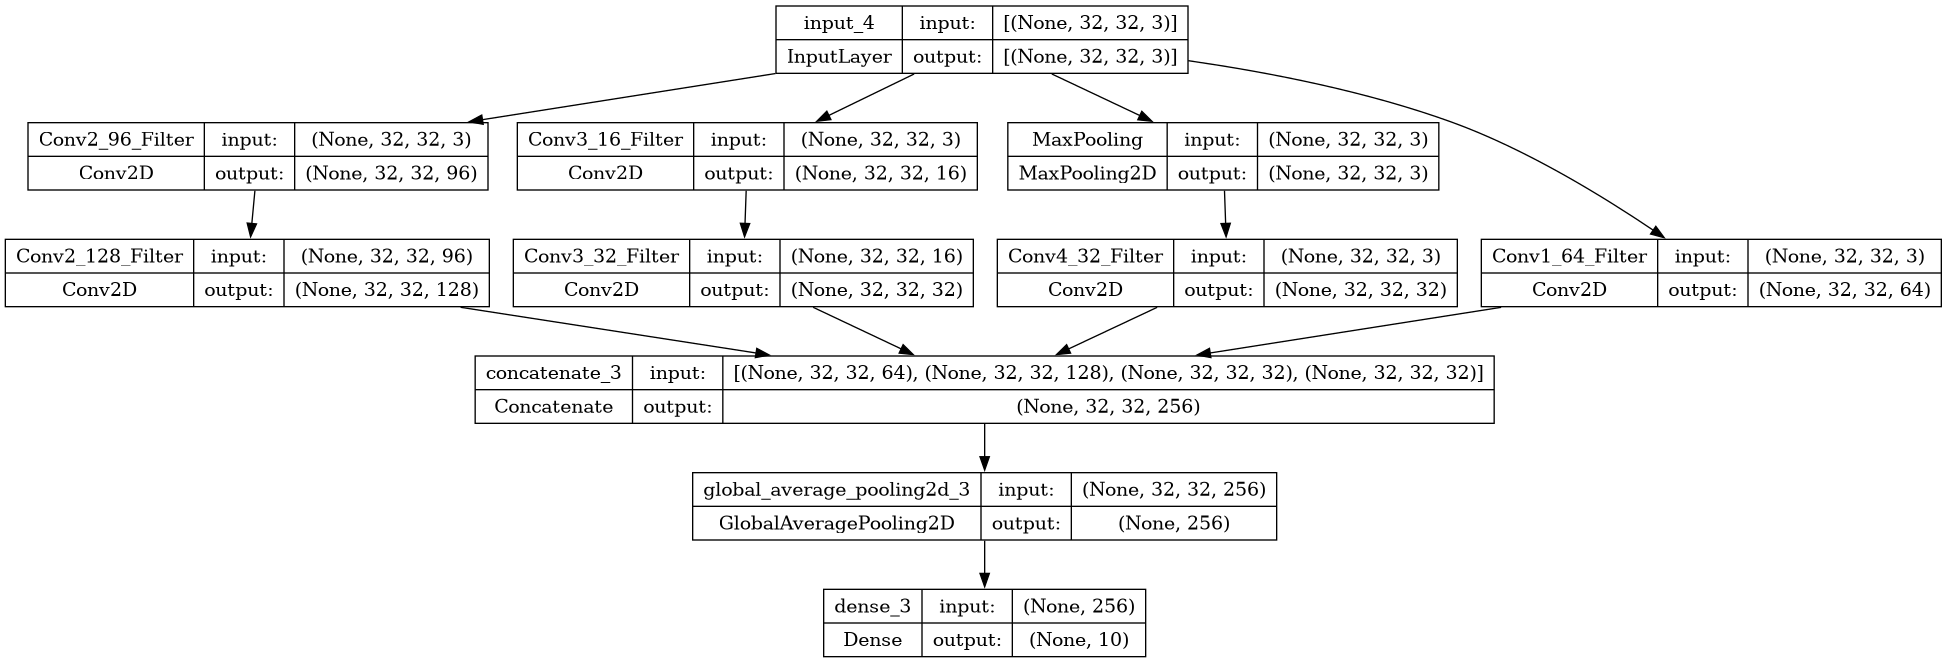

In [ ]:
input_layer = Input(shape=(32, 32, 3))

# 1x1 Convolution
# input (32,32,3)
# output (32,32,64)
conv1x1_1 = Conv2D(64, (1, 1), padding='same', activation='relu', name='Conv1_64_Filter')(input_layer)

# 1x1 Convolution followed by 3x3 Convolution
# input(32,32,3)
# output 1x1 (32,32,96)
# output 3x3 (32,32,128)
conv1x1_2 = Conv2D(96, (1, 1), padding='same', activation='relu', name='Conv2_96_Filter')(input_layer)
conv3x3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='Conv2_128_Filter')(conv1x1_2)

# 1x1 Convolution followed by 5x5 Convolution
# input (32,32,3)
# output 1x1 (32,32,16)
# output 5x5 (32,32,32)
conv1x1_3 = Conv2D(16, (1, 1), padding='same', activation='relu', name='Conv3_16_Filter')(input_layer)
conv5x5 = Conv2D(32, (5, 5), padding='same', activation='relu', name='Conv3_32_Filter')(conv1x1_3)

# 3x3 MaxPooling followed by 1x1 Convolution
# input (32,32,3)
# output maxpool (32,32,3)
# output 1x1 (32,32,32)
maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same', name='MaxPooling')(input_layer)
conv1x1_4 = Conv2D(32, (1, 1), padding='same', activation='relu', name='Conv4_32_Filter')(maxpool)

# concatenate output (32, 32, 256)
inception_module_output = concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_4], axis=-1)

global_avg_pooling = GlobalAveragePooling2D()(inception_module_output)

output = Dense(10, activation='softmax')(global_avg_pooling)

inception_model = Model(inputs=input_layer, outputs=output)

inception_model.summary()
plot_model(inception_model, show_shapes=True, to_file='inception_model.png')

In [ ]:
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = inception_model.fit(x_train, y_train, epochs=10,batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 15s 8ms/step - loss: 2.0176 - accuracy: 0.2428 - val_loss: 1.9399 - val_accuracy: 0.2741
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.8655 - accuracy: 0.3132 - val_loss: 1.7885 - val_accuracy: 0.3385
Epoch 3/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.7629 - accuracy: 0.3530 - val_loss: 1.7459 - val_accuracy: 0.3596
Epoch 4/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6992 - accuracy: 0.3793 - val_loss: 1.6611 - val_accuracy: 0.3875
Epoch 5/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6438 - accuracy: 0.4007 - val_loss: 1.6174 - val_accuracy: 0.4057
Epoch 6/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6097 - accuracy: 0.4136 - val_loss: 1.5879 - val_accuracy: 0.4236
Epoch 7/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.5800 - accuracy: 0.4247 - val_loss: 1.5735 - val_ac

In [ ]:
score = inception_model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

pred = inception_model.predict(x_test)

print('Accuracy Score =',round(np.max(history.history['accuracy']) * 100, 2) , '%')

313/313 [==============================] - 1s 4ms/step - loss: 1.5189 - accuracy: 0.4507
Test loss: 1.518859624862671
Test accuracy: 0.4507000148296356
313/313 [==============================] - 1s 2ms/step
Accuracy Score = 45.8 %


### **Inception Model on Images with depth 192**
- we add 3 conv layers (64,128,192) before Inception architecture to increase the depth from 3 to 192

In [ ]:
input_layer = Input(shape=(32, 32, 3))

x = Conv2D(64, (1, 1), activation='relu')(input_layer)
x = Conv2D(128, (1, 1), activation='relu')(x)
x = Conv2D(192, (1, 1), activation='relu')(x)

# 1x1 Convolution
conv1x1_1 = Conv2D(64, (1, 1), padding='same', activation='relu', name='Conv1_64_Filter')(x)

# 1x1 Convolution followed by 3x3 Convolution
conv1x1_2 = Conv2D(96, (1, 1), padding='same', activation='relu', name='Conv2_96_Filter')(x)
conv3x3 = Conv2D(128, (3, 3), padding='same', activation='relu', name='Conv2_128_Filter')(conv1x1_2)

# 1x1 Convolution followed by 5x5 Convolution
conv1x1_3 = Conv2D(16, (1, 1), padding='same', activation='relu', name='Conv3_16_Filter')(x)
conv5x5 = Conv2D(32, (5, 5), padding='same', activation='relu', name='Conv3_32_Filter')(conv1x1_3)

# 3x3 MaxPooling followed by 1x1 Convolution
maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same', name='MaxPooling')(x)
conv1x1_4 = Conv2D(32, (1, 1), padding='same', activation='relu', name='Conv4_32_Filter')(maxpool)

inception_module_output = concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_4], axis=-1)

global_avg_pooling = GlobalAveragePooling2D()(inception_module_output)

output = Dense(10, activation='softmax')(global_avg_pooling)

inception_model2 = Model(inputs=input_layer, outputs=output)

inception_model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 32, 32, 64)           256       ['input_3[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 32, 32, 128)          8320      ['conv2d_6[0][0]']            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 32, 32, 192)          24768     ['conv2d_7[0][0]']            
                                                                                            

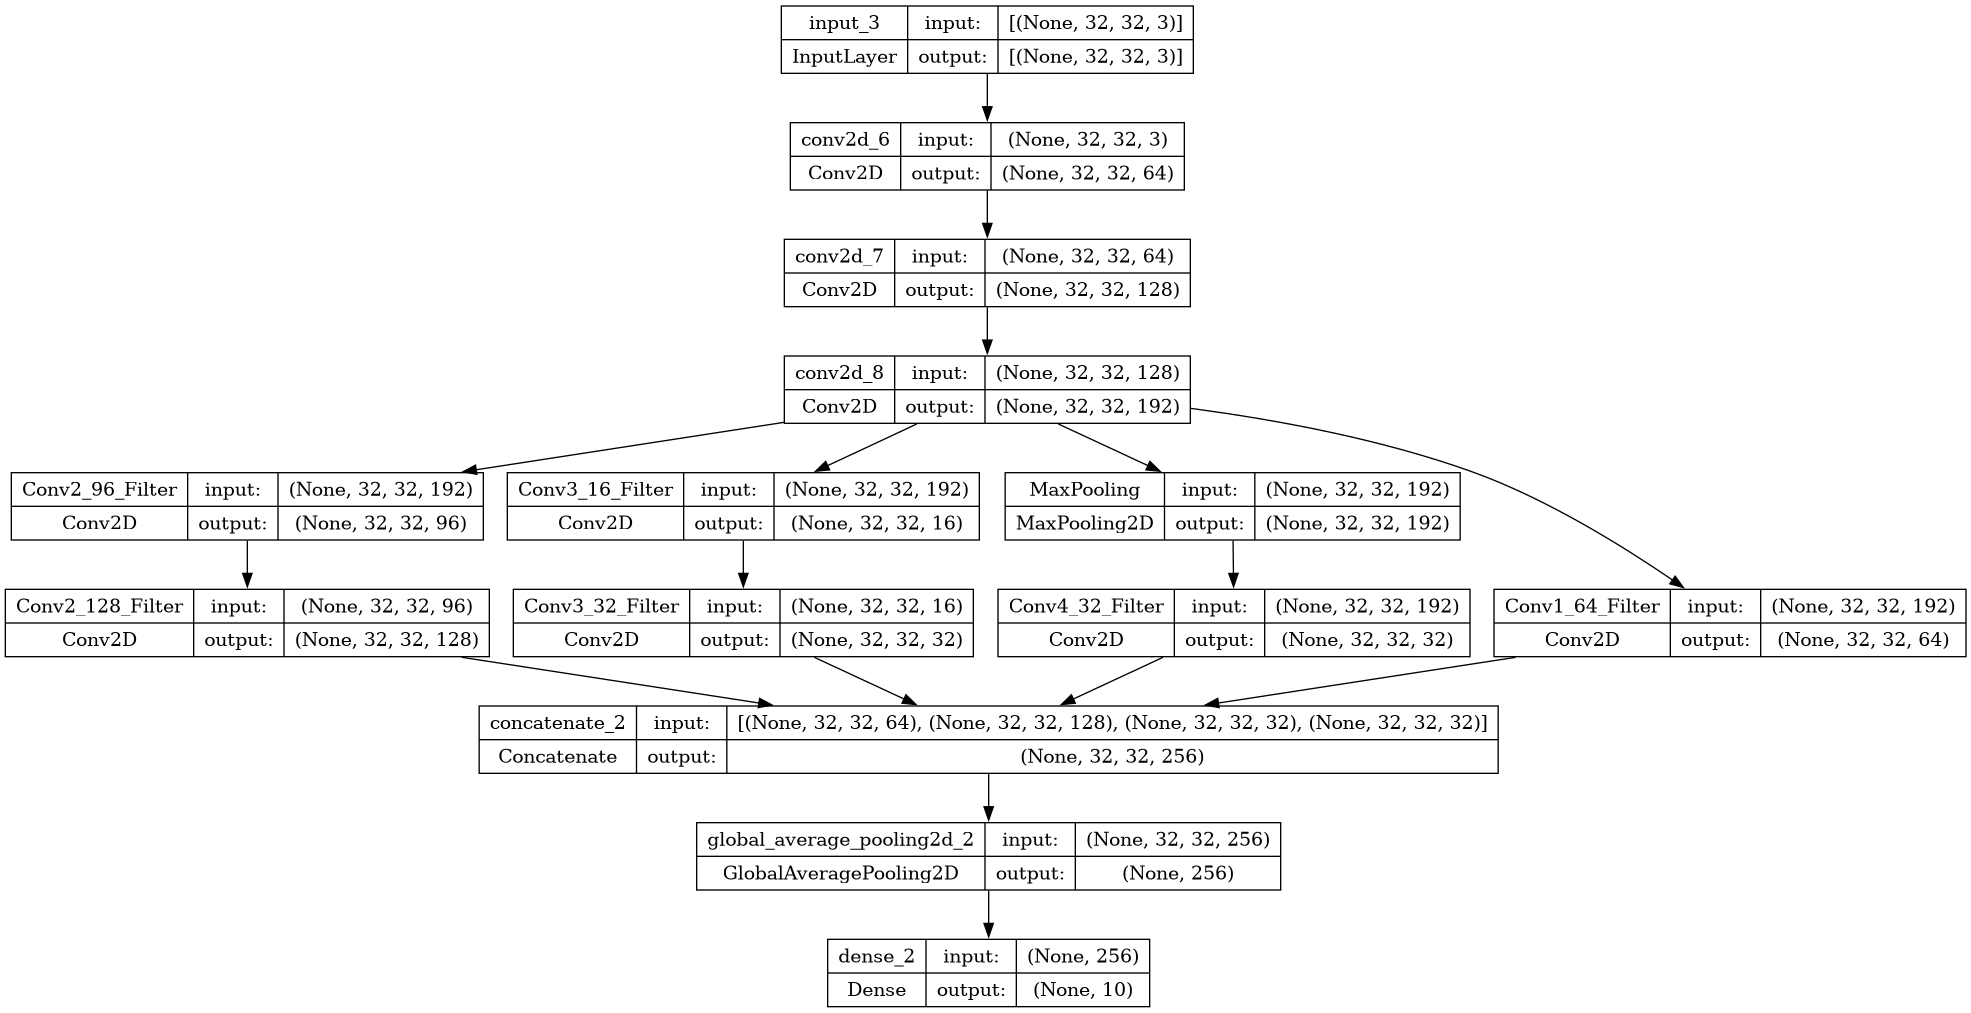

In [ ]:
plot_model(inception_model2, show_shapes=True, to_file='inception_model2.png')

In [ ]:
inception_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history2 = inception_model2.fit(x_train, y_train, epochs=10,batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 33s 14ms/step - loss: 1.9644 - accuracy: 0.2612 - val_loss: 1.7766 - val_accuracy: 0.3580
Epoch 2/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.6611 - accuracy: 0.3918 - val_loss: 1.6167 - val_accuracy: 0.4128
Epoch 3/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.5511 - accuracy: 0.4387 - val_loss: 1.5756 - val_accuracy: 0.4430
Epoch 4/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.4892 - accuracy: 0.4657 - val_loss: 1.4778 - val_accuracy: 0.4784
Epoch 5/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.4324 - accuracy: 0.4854 - val_loss: 1.4556 - val_accuracy: 0.4938
Epoch 6/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.4012 - accuracy: 0.5013 - val_loss: 1.4620 - val_accuracy: 0.4983
Epoch 7/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.3635 - accuracy: 0.5178 - val_loss: 1.4179 -

In [ ]:
score2 = inception_model2.evaluate(x_test, y_test)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

313/313 [==============================] - 2s 5ms/step - loss: 1.3091 - accuracy: 0.5488
Test loss: 1.3091039657592773
Test accuracy: 0.548799991607666


In [ ]:
pred2 = inception_model2.predict(x_test)

313/313 [==============================] - 1s 4ms/step


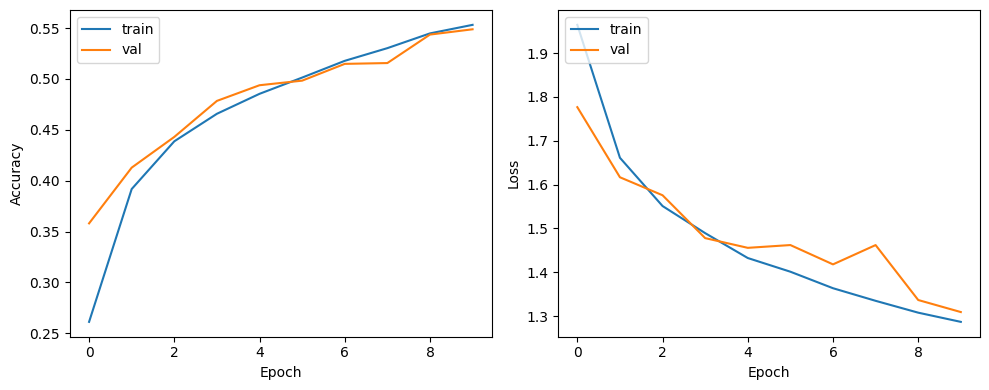

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
print('Accuracy Score =',round(np.max(history2.history['accuracy']) * 100, 2) , '%')

Accuracy Score = 55.32 %


### **Pre-trained Inception Model**


In [ ]:
pretrained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

x = pretrained_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 149, 149, 32)         864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d_9[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0]

In [ ]:
x_train = np.array([cv2.resize(img, (224,224)) for img in x_train[:,:,:,:][:3000]])
x_test = np.array([cv2.resize(img, (224,224)) for img in x_test[:,:,:,:][:3000]])
y_train = y_train[:3000]
y_test = y_test[:3000]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3000, 224, 224, 3), (3000, 10), (3000, 224, 224, 3), (3000, 10))

In [ ]:
x_train_resized = tf.image.resize(x_train, (299, 299))
x_test_resized = tf.image.resize(x_test, (299, 299))

x_train_resized.shape, x_test_resized.shape

(TensorShape([3000, 299, 299, 3]), TensorShape([3000, 299, 299, 3]))

In [ ]:
history3 = model.fit(x_train_resized, y_train, epochs=10, batch_size=32, validation_data=(x_test_resized, y_test))

Epoch 1/10
94/94 [==============================] - 74s 396ms/step - loss: 1.5637 - accuracy: 0.4740 - val_loss: 3.0194 - val_accuracy: 0.2267
Epoch 2/10
94/94 [==============================] - 30s 316ms/step - loss: 1.0325 - accuracy: 0.6553 - val_loss: 1.6734 - val_accuracy: 0.5097
Epoch 3/10
94/94 [==============================] - 30s 316ms/step - loss: 0.7833 - accuracy: 0.7267 - val_loss: 2.0818 - val_accuracy: 0.5210
Epoch 4/10
94/94 [==============================] - 30s 316ms/step - loss: 0.6295 - accuracy: 0.7870 - val_loss: 3.0817 - val_accuracy: 0.4463
Epoch 5/10
94/94 [==============================] - 30s 316ms/step - loss: 0.5390 - accuracy: 0.8200 - val_loss: 3.8966 - val_accuracy: 0.3480
Epoch 6/10
94/94 [==============================] - 30s 316ms/step - loss: 0.4473 - accuracy: 0.8480 - val_loss: 1.4893 - val_accuracy: 0.5920
Epoch 7/10
94/94 [==============================] - 30s 316ms/step - loss: 0.3638 - accuracy: 0.8773 - val_loss: 1.4296 - val_accuracy: 0.6483

In [ ]:
score3 = model.evaluate(x_test_resized, y_test)
print(f'Test accuracy: {score3[1]*100}:.2')

94/94 [==============================] - 7s 76ms/step - loss: 1.9917 - accuracy: 0.5640
Test accuracy: 56.40000104904175:.2


In [ ]:
pred3 = model.predict(x_test_resized)

94/94 [==============================] - 8s 72ms/step


In [ ]:
print(f'Pretrained Accuracy: {round(score3[1], 3) * 100}%')

Pretrained Accuracy: 56.39999999999999%


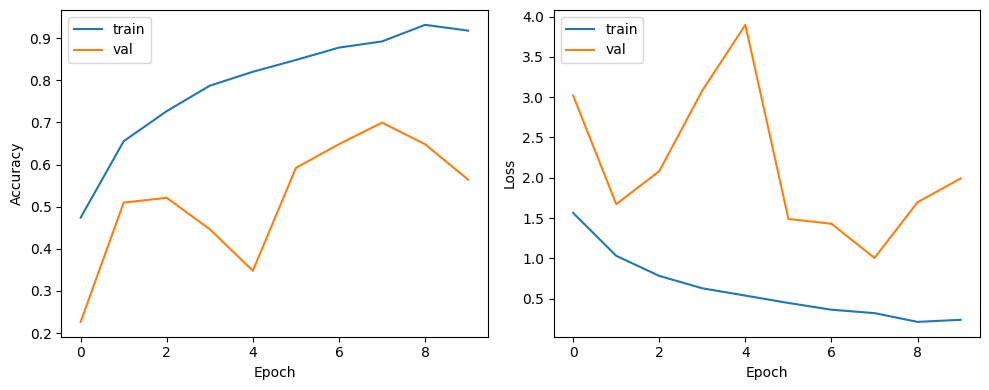

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

### **Conclusion**
- Pre-trained is better than from scratch
- Increasing the depth of the data to be 32,32,192 is better than original data 32,32,3

In [ ]:
print('32,32,192 Accuracy =',round(np.max(history.history['val_accuracy']) * 100, 2) , '%')
print('32,32,3 Accuracy =',round(np.max(history2.history['val_accuracy']) * 100, 2) , '%')
print('Pretrained Accuracy =',round(np.max(history3.history['val_accuracy']) * 100, 2) , '%')

32,32,192 Accuracy = 54.88 %
32,32,3 Accuracy = 45.81 %
Pretrained Accuracy = 69.93 %
